In [61]:
import glob
import math
import os
import subprocess
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats

sns.set()

In [62]:
SCENARIO_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = f'{SCENARIO_DIR}/results'
SCENARIO = "Default"
DB_PATH = f'{RESULTS_DIR}/{SCENARIO}.db'
#DB_PATH = '/home/cian/tmp/test.db'
PLOT_HEIGHT = 4
PLOT_ASPECT = 2

In [101]:
import sqlite3

#sql = '''select * from results;'''
#sql = '''select * from results limit 100000;'''
sql = '''select * from results where seconds > 5400;'''
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql(sql, conn)

In [81]:
df.sample(10)

node_id  run_id   seconds  frame_error_rate controller  mpr  \
58420       353       0  6452.099               0.0     "CACC"  0.0   
205589      288       5  5870.700               0.5     "CACC"  0.2   
226298      328       5  6327.099               0.5     "CACC"  0.2   
266076      408       5  7110.099               0.5     "CACC"  0.2   
72026       384       0  6756.800               0.0     "CACC"  0.0   
216914      317       5  6016.099               0.5     "CACC"  0.2   
115971      291       4  5838.099               0.0     "CACC"  0.2   
51388       352       0  6219.800               0.0     "CACC"  0.0   
218693      326       5  6114.099               0.5     "CACC"  0.2   
249478      376       5  6772.800               0.5     "CACC"  0.2   

        mobility_posx  mobility_posy  mobility_acceleration  \
58420             NaN            NaN                    NaN   
205589    4719.547021    5471.542760               0.000000   
226298            NaN            NaN                    NaN   
266076            NaN            NaN                    NaN   
72026    10700.335257    2177.835988              -0.569474   
216914            NaN            NaN                    NaN   
115971            NaN            NaN                    NaN   
51388    13907.038762     948.661695               0.983121   
218693            NaN            NaN                    NaN   
249478    6996.602897    4462.445080              -0.190188   

        mobility_co2emission  ...  appl_speed  appl_acceleration  \
58420                    NaN  ...   31.457755          -0.314427   
205589              4.430006  ...   27.777800           0.000000   
226298                   NaN  ...   27.777800           0.000000   
266076                   NaN  ...   27.777800           0.000000   
72026               0.400264  ...   25.857756           0.457532   
216914                   NaN  ...   24.839375           0.107864   
115971                   NaN  ...   28.910112          -0.001684   
51388              11.242740  ...   28.139678          -0.630270   
218693                   NaN  ...   32.447273          -0.051911   
249478              3.065336  ...   27.367309          -0.199165   

        appl_leaderDistance  appl_relativeSpeed  appl_controllerAcceleration  \
58420         8.514316e-317       9.387247e-323                 0.000000e+00   
205589        -1.000000e+00        0.000000e+00                -7.105430e-14   
226298         1.512050e+02        1.198370e+00                -7.105430e-14   
266076         8.040360e+02       -1.742460e+00                 7.105430e-14   
72026         8.910723e-317       9.387247e-323                 0.000000e+00   
216914        7.579821e-317       9.387247e-323                 0.000000e+00   
115971        1.074363e-316       9.387247e-323                 0.000000e+00   
51388         8.276912e-317       9.387247e-323                 0.000000e+00   
218693        7.997002e-317       9.387247e-323                 0.000000e+00   
249478        7.247579e-317       9.387247e-323                 0.000000e+00   

        appl_distanceTravelled  appl_laneIdx  prot_nodeId  prot_busyTime  \
58420              8904.558657             1          NaN            NaN   
205589            11552.815863             0          NaN            NaN   
226298            12105.715153             0          NaN            NaN   
266076             5831.661818             1          NaN            NaN   
72026              4911.468157             0          NaN            NaN   
216914             6025.181782             0          NaN            NaN   
115971             9850.902905             0          NaN            NaN   
51388              1490.979112             0          NaN            NaN   
218693             7708.415243             1          NaN            NaN   
249478             8929.556059             0          NaN            NaN   

        prot_collisions  
58420               NaN  
205589       

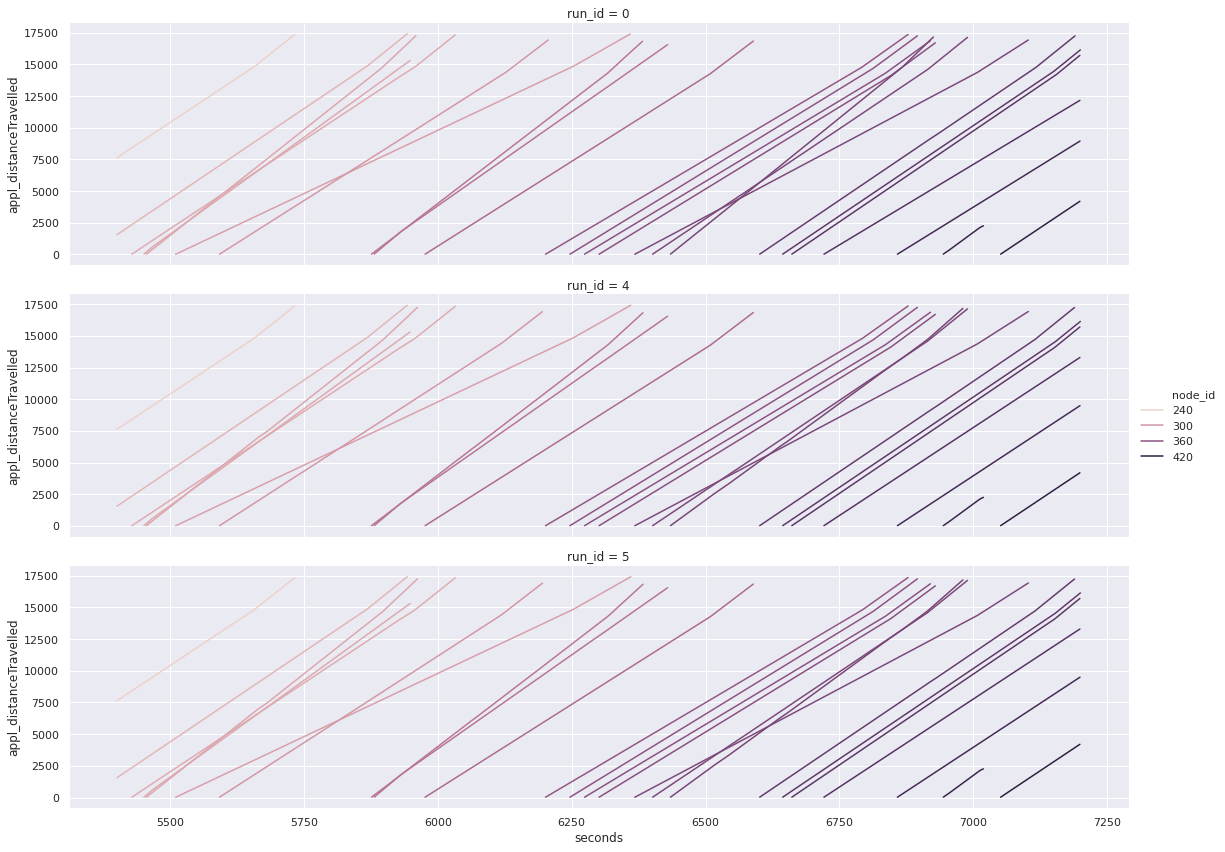

In [82]:
node_ids = df.node_id.sample(25)
sample = df[df.node_id.isin(node_ids)]
palette=sns.color_palette("Set1", len(node_ids))
sns.relplot(data=sample, x='seconds', y='appl_distanceTravelled', kind='line', hue='node_id', row="run_id", ci=None, estimator=None, height=PLOT_HEIGHT, aspect=PLOT_ASPECT*2)

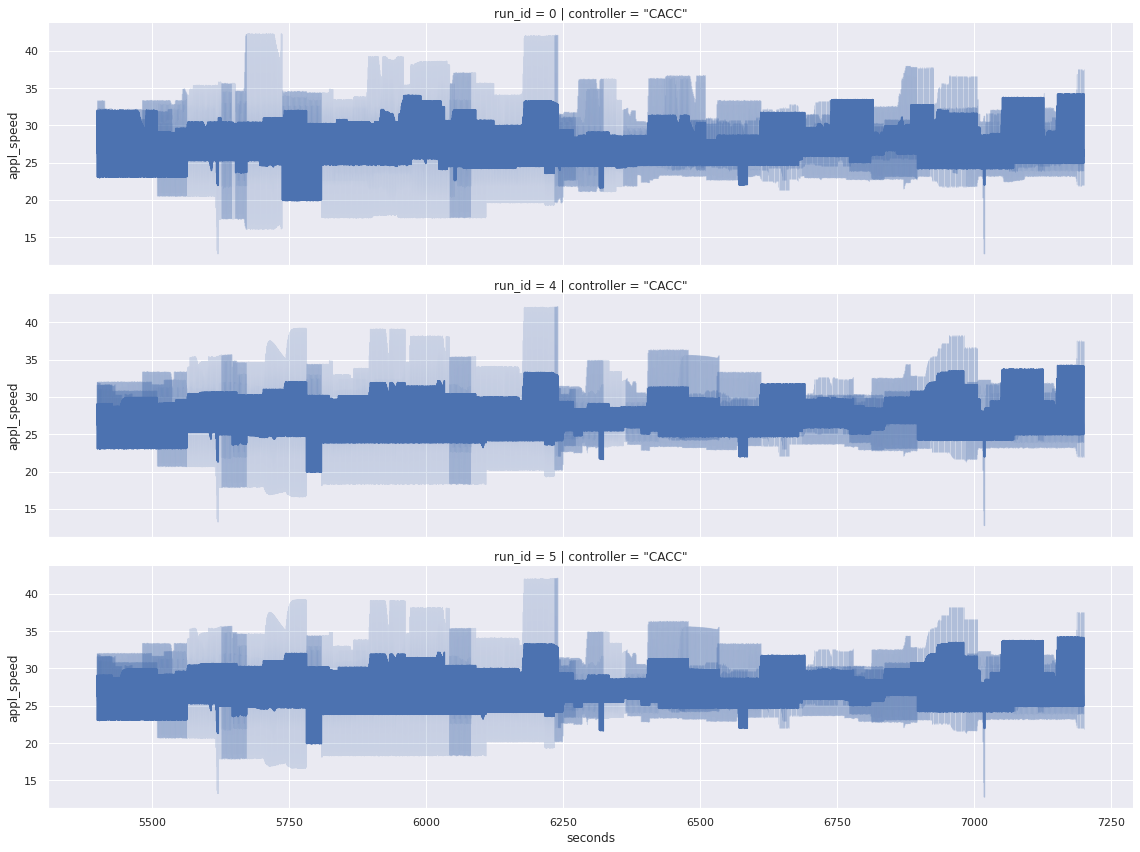

In [83]:
sns.relplot(x='seconds', y='appl_speed', kind='line', row="run_id", col="controller", data=df, height=PLOT_HEIGHT, aspect=PLOT_ASPECT*2, ci='sd')

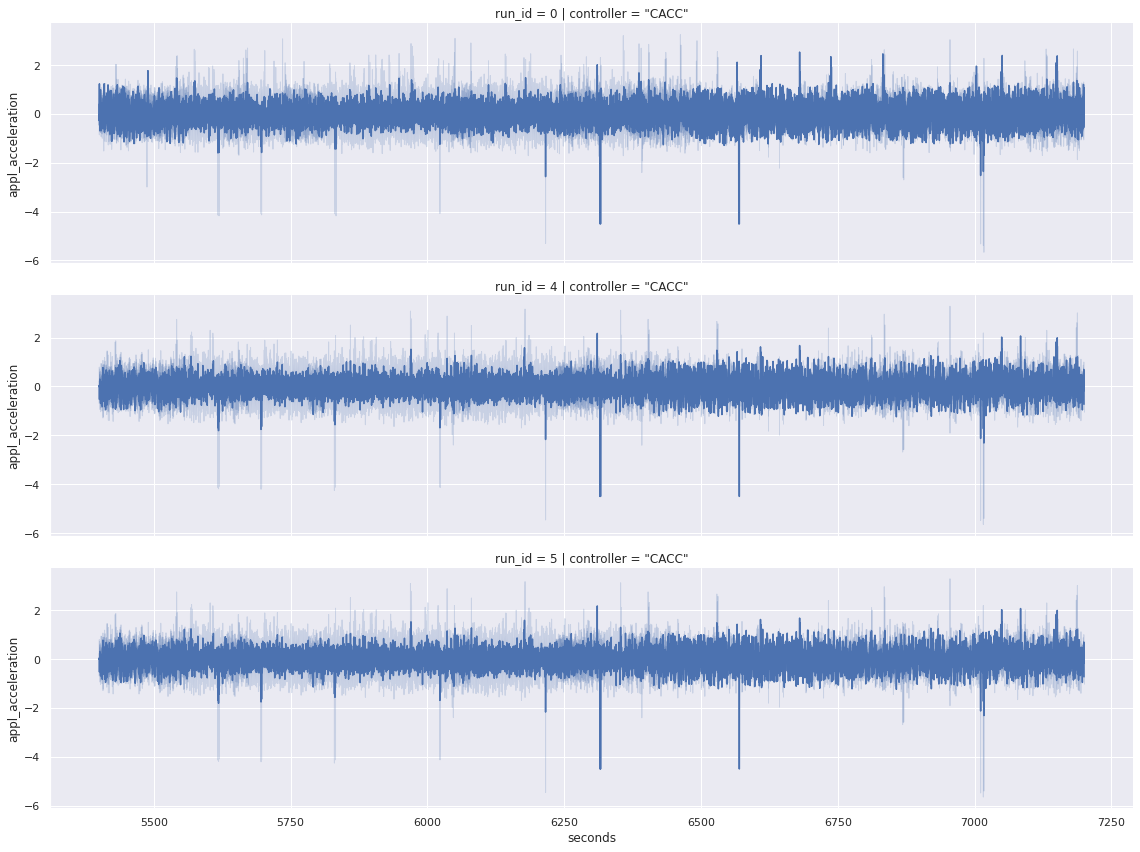

In [84]:
sns.relplot(x='seconds', y='appl_acceleration', kind='line', row="run_id", col='controller', data=df, height=PLOT_HEIGHT, aspect=PLOT_ASPECT*2, ci='sd')

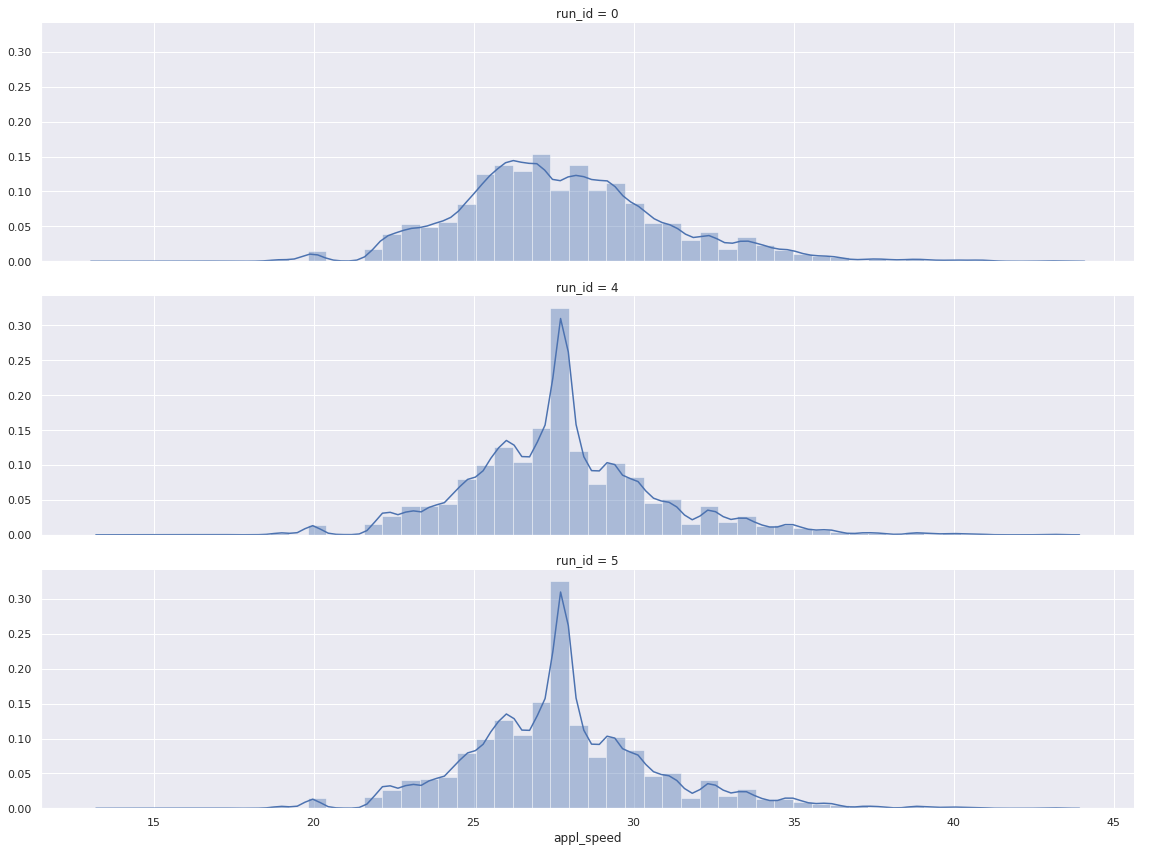

In [86]:
g = sns.FacetGrid(df, row="run_id", height=PLOT_HEIGHT, aspect=PLOT_ASPECT*2)
g.map(sns.distplot, "appl_speed")
g.add_legend()

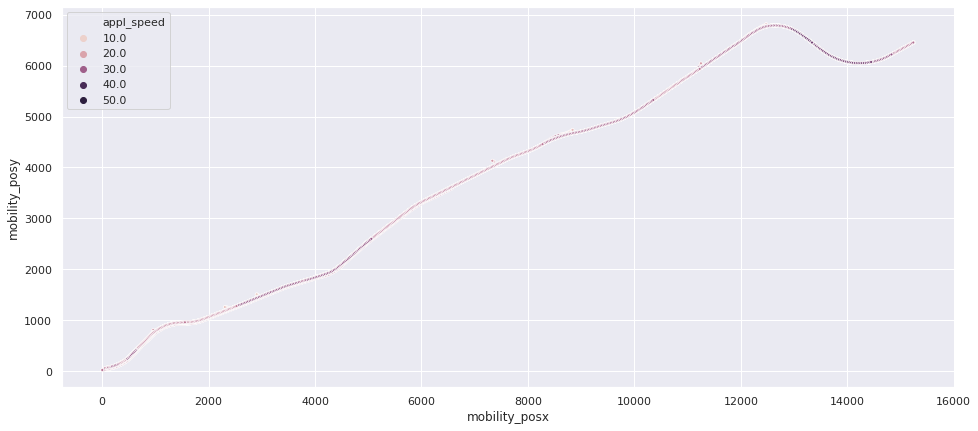

In [135]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 7)
x_flipped = df.mobility_posx.max() - df.mobility_posx
sns.scatterplot(data=df[df.run_id==0], x=x_flipped, y='mobility_posy', hue='appl_speed', marker='.', sizes=(1,1), ax=ax)

In [110]:
from itertools import combinations

def do_comparison(datasets, attrs, p=0.05):
    pairs = combinations(datasets.items(), r=2)
    for pair in pairs:
        (a_name, a_data), (b_name, b_data) = pair
        for attr in attrs:
            sr = stats.ks_2samp(a_data[attr], b_data[attr])
            do_or_dont = "do" if sr.pvalue <= p else "do not"
            fig, axes = plt.subplots(1, 2, sharey=True, figsize=(PLOT_HEIGHT*PLOT_ASPECT*2, PLOT_HEIGHT))
            axes[0].set_title(f"A")
            axes[1].set_title(f"B")
            fig.suptitle(f"{a_name} (A) and {b_name} (B) {do_or_dont} differ significantly by {attr}")
            fig.text(s=f"statistic={sr.statistic:.3f} pvalue={sr.pvalue:.3f} (two-tailed)", x=0, y=0)
            sns.distplot(a_data[attr].dropna(), ax=axes[0])
            sns.distplot(b_data[attr].dropna(), ax=axes[1])

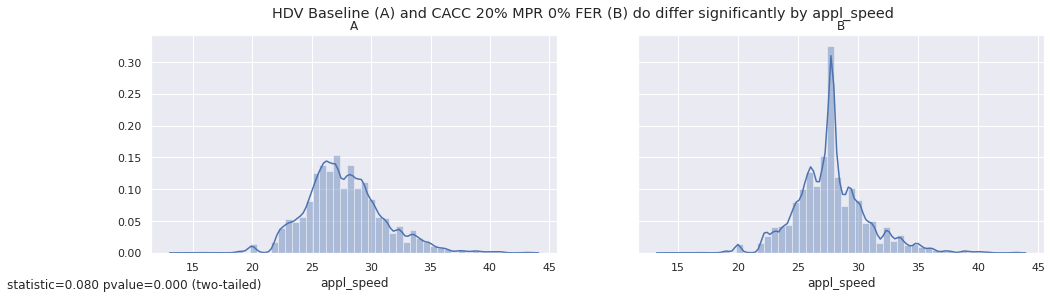

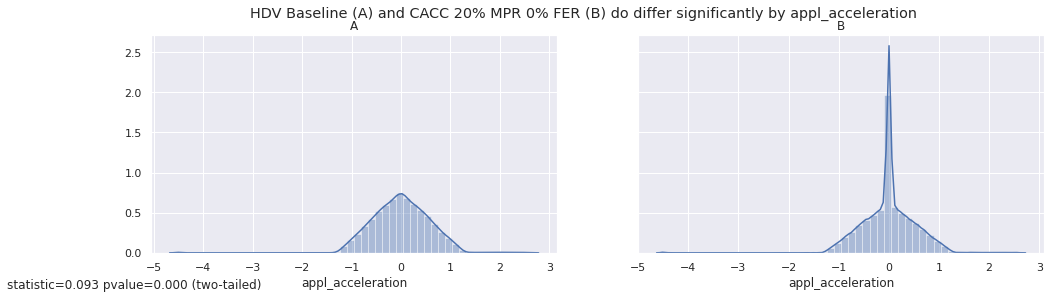

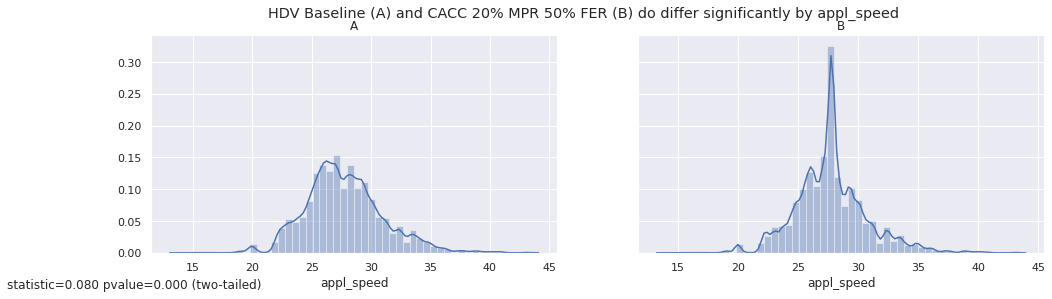

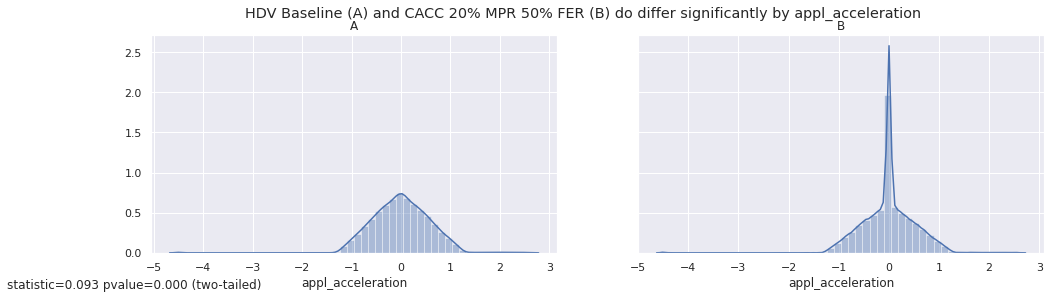

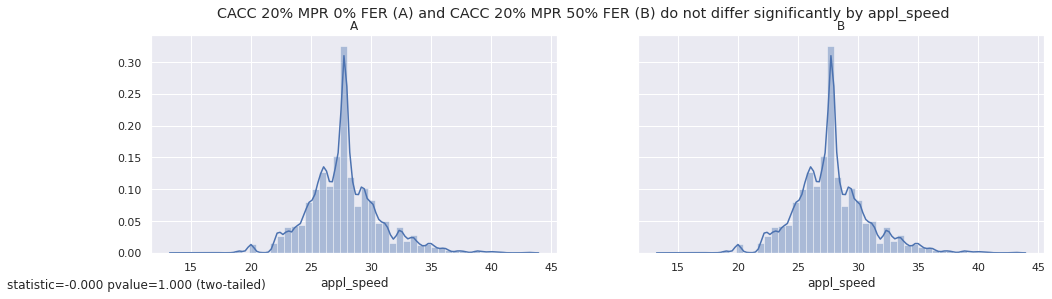

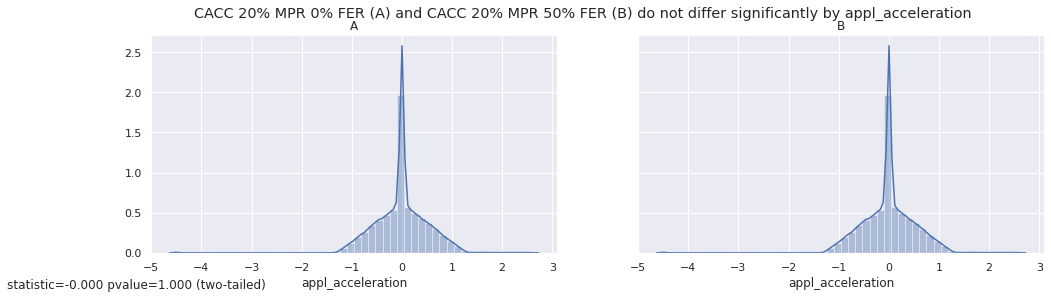

In [111]:
datasets = {
    "HDV Baseline": df[df.run_id==0],
    "CACC 20% MPR 0% FER": df[df.run_id==4],
    "CACC 20% MPR 50% FER": df[df.run_id==5],
}
attrs = ['appl_speed', 'appl_acceleration']
do_comparison(datasets, attrs)